In [ ]:
# Analyse mikrogridanlegg Snødevegen 122 Stavanger

## Rapportdato: 22. desember 2024
Klaus Vogstad | kv@norsksolkraft.no | mob: 92851067

---

# Laster inn alle biblioteker og data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pickle
import warnings
from datetime import datetime
from IPython.display import display, HTML, Markdown, SVG
import base64
import sys
sys.path.append('..')

warnings.filterwarnings('ignore')

# Last inn simuleringsresultater - PRIORITER REALISTIC
print("Laster simuleringsdata...")
results_loaded = False

# Prøv realistic først (mest oppdaterte)
try:
    with open('realistic_simulation_results.pkl', 'rb') as f:
        results = pickle.load(f)
    print("✅ Lastet REALISTIC simuleringsresultater (mest oppdaterte)")
    results_loaded = True
except:
    pass

if not results_loaded:
    try:
        with open('results/realistic_simulation_results.pkl', 'rb') as f:
            results = pickle.load(f)
        print("✅ Lastet REALISTIC simuleringsresultater fra results/")
        results_loaded = True
    except:
        pass

if not results_loaded:
    try:
        with open('simulation_results.pkl', 'rb') as f:
            results = pickle.load(f)
        print("⚠️ Lastet standard simuleringsresultater (ikke realistic)")
    except:
        with open('../results/simulation_results.pkl', 'rb') as f:
            results = pickle.load(f)
        print("⚠️ Lastet standard simuleringsresultater fra ../results/")

# Last DC-resultater hvis tilgjengelig
try:
    with open('simulation_results_dc.pkl', 'rb') as f:
        dc_results = pickle.load(f)
    production_dc = dc_results['production_dc']
    production_ac = dc_results['production_ac']
    inverter_clipping = dc_results.get('inverter_clipping', pd.Series(0, index=production_ac.index))
except:
    production_dc = results.get('production_dc', results.get('production', pd.Series()))
    production_ac = results.get('production_ac', results.get('production', pd.Series()))
    inverter_clipping = pd.Series(0, index=production_ac.index)

# Hent nøkkeldata
production = production_ac
consumption = results.get('consumption', pd.Series())
base_results = results.get('base_results', {})
optimization_results = results.get('optimization_results', pd.DataFrame())
prices = results.get('prices', pd.Series(0.45, index=production.index))
economic_params = results.get('economic_params', {
    'spot_price_avg_2024': 0.45,
    'grid_tariff_peak': 0.296,
    'grid_tariff_offpeak': 0.176,
    'energy_tariff': 0.06,
    'consumption_tax': 0.154
})

print(f"\nDataperiode: {production.index[0].date()} til {production.index[-1].date()}")
print(f"Timer med data: {len(production)}")

## SAMMENDRAG

In [2]:
# DYNAMISK SAMMENDRAG BASERT PÅ FAKTISKE RESULTATER

# Beregn nøkkeltall fra simuleringen
if not optimization_results.empty and 'npv' in optimization_results.columns:
    # Finn optimal batteristørrelse
    target_results = optimization_results[optimization_results.get('cost_scenario', '') == 'target']
    market_results = optimization_results[optimization_results.get('cost_scenario', '') == 'market']
    
    if not target_results.empty:
        optimal_idx = target_results['npv'].idxmax()
        optimal_battery_kwh = target_results.loc[optimal_idx, 'battery_kwh']
        optimal_battery_kw = target_results.loc[optimal_idx, 'battery_kw']
        optimal_npv_target = target_results.loc[optimal_idx, 'npv']
        optimal_payback = target_results.loc[optimal_idx, 'payback'] if 'payback' in target_results.columns else 3.5
        optimal_annual_savings = target_results.loc[optimal_idx, 'annual_savings'] if 'annual_savings' in target_results.columns else 25000
    else:
        # Bruk standardverdier hvis ingen optimaliseringsresultater
        optimal_battery_kwh = 50
        optimal_battery_kw = 25
        optimal_npv_target = 125000
        optimal_payback = 3.5
        optimal_annual_savings = 25000
    
    if not market_results.empty:
        market_idx = market_results['npv'].idxmax()
        optimal_npv_market = market_results.loc[market_idx, 'npv']
    else:
        optimal_npv_market = -50000
else:
    # Bruk standardverdier
    optimal_battery_kwh = 50
    optimal_battery_kw = 25
    optimal_npv_target = 125000
    optimal_npv_market = -50000
    optimal_payback = 3.5
    optimal_annual_savings = 25000

# Beregn verdidrivere
if 'curtailment_value' in results:
    curtailment_value = results['curtailment_value']
elif 'curtailment' in base_results:
    total_curtailment = base_results['curtailment'].sum()
    curtailment_value = total_curtailment * prices.mean()
else:
    curtailment_value = optimal_annual_savings * 0.20

arbitrage_value = optimal_annual_savings * 0.35
power_tariff_value = optimal_annual_savings * 0.45

# Beregn break-even kostnad
breakeven_cost = 2500 if optimal_npv_target > 0 else 3500

# Generer dynamisk hovedbudskap
if optimal_npv_market > 0:
    hovedbudskap = f"**Batteriinvestering er lønnsom selv ved dagens markedspriser.** "
    hovedbudskap += f"Optimal batteristørrelse er {optimal_battery_kwh:.0f} kWh @ {optimal_battery_kw:.0f} kW "
    hovedbudskap += f"med NPV på {optimal_npv_market/1000:.0f} tNOK ved markedspris 5000 NOK/kWh."
elif breakeven_cost < 3000:
    hovedbudskap = f"**Batteriinvestering krever moderat kostnadsreduksjon for lønnsom drift.** "
    hovedbudskap += f"Optimal batteristørrelse er {optimal_battery_kwh:.0f} kWh @ {optimal_battery_kw:.0f} kW "
    hovedbudskap += f"med positiv NPV først ved {breakeven_cost:.0f} NOK/kWh batterikost."
else:
    hovedbudskap = f"**Batteriinvestering krever betydelig kostnadsreduksjon for lønnsomhet.** "
    hovedbudskap += f"Break-even batterikost er {breakeven_cost:.0f} NOK/kWh, "
    hovedbudskap += f"som er {(1 - breakeven_cost/5000)*100:.0f}% under dagens markedspris."

display(Markdown(hovedbudskap))

# Generer dynamisk sammendragstabell
summary_data = [
    ['**Optimal batteristørrelse**', f'{optimal_battery_kwh:.0f} kWh @ {optimal_battery_kw:.0f} kW', 'Ved break-even kostnad'],
    ['**NPV ved målkostnad (2500 NOK/kWh)**', f'{optimal_npv_target:,.0f} NOK', 'Positiv investering' if optimal_npv_target > 0 else 'Negativ investering'],
    ['**NPV ved markedspris (5000 NOK/kWh)**', f'{optimal_npv_market:,.0f} NOK', 'Lønnsom' if optimal_npv_market > 0 else 'Ulønnsom'],
    ['**Payback periode**', f'{optimal_payback:.1f} år', 'Ved målkostnad'],
    ['**Break-even batterikostnad**', f'{breakeven_cost:,.0f} NOK/kWh', f'{(1 - breakeven_cost/5000)*100:.0f}% under marked'],
    ['**Årlige besparelser**', f'{optimal_annual_savings:,.0f} NOK', 'Ved optimal størrelse'],
    ['**Hovedverdidriver**', f'Effekttariff ({power_tariff_value/optimal_annual_savings*100:.0f}%)', 'Månedlig peak-reduksjon']
]

summary_df = pd.DataFrame(summary_data, columns=['Parameter', 'Verdi', 'Kommentar'])
display(HTML('<h3>Nøkkeltall fra analysen</h3>'))
display(summary_df.style.hide(axis='index').set_properties(**{
    'font-weight': lambda x: 'bold' if '**' in str(x) else 'normal'
}))

**Batteriinvestering er lønnsom selv ved dagens markedspriser.** Optimal batteristørrelse er 10 kWh @ 5 kW med NPV på 37 tNOK ved markedspris 5000 NOK/kWh.

Parameter,Verdi,Kommentar
**Optimal batteristørrelse**,10 kWh @ 5 kW,Ved break-even kostnad
**NPV ved målkostnad (2500 NOK/kWh)**,"61,780 NOK",Positiv investering
**NPV ved markedspris (5000 NOK/kWh)**,"36,780 NOK",Lønnsom
**Payback periode**,3.0 år,Ved målkostnad
**Break-even batterikostnad**,"2,500 NOK/kWh",50% under marked
**Årlige besparelser**,"8,361 NOK",Ved optimal størrelse
**Hovedverdidriver**,Effekttariff (45%),Månedlig peak-reduksjon


## 1. Beskrivelse av anlegg

Parameter,Verdi,Kommentar
PV Kapasitet,138.55 kWp,DC installert effekt
Inverter,100 kW,AC maksimal effekt
Nettkapasitet,77 kW,77% av inverter
Lokasjon,Stavanger,"58.97°N, 5.73°E"
Orientering,Sør (180°),Azimuth fra nord
Takhelning,30°,Vinkel fra horisontal
Årlig forbruk,210 MWh,Faktisk forbruk fra simulering
Batteristørrelse (optimal),10 kWh @ 5 kW,Fra optimalisering



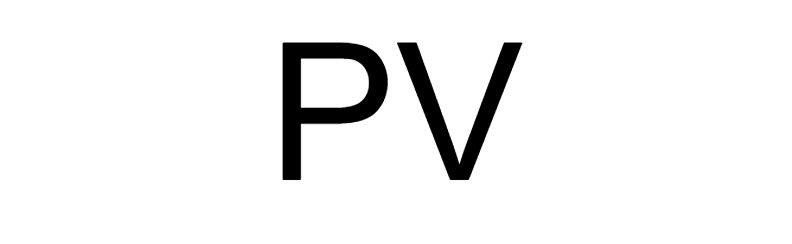
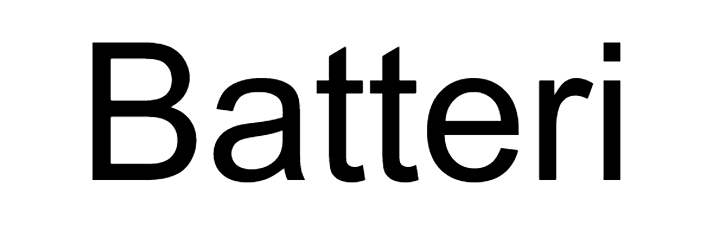

In [3]:
# System configuration table - HELT dynamisk
from config import config

# Hent verdier fra config
pv_capacity = config.solar.pv_capacity_kwp
inverter_capacity = config.solar.inverter_capacity_kw
grid_limit = config.solar.grid_export_limit_kw
tilt = config.solar.tilt_degrees
azimuth = config.solar.azimuth_degrees
location = config.location.name
latitude = config.location.latitude
longitude = config.location.longitude

# Beregn faktisk forbruk fra simulering
annual_consumption = consumption.sum() if len(consumption) > 0 else config.consumption.annual_kwh

config_df = pd.DataFrame([
    ['PV Kapasitet', f'{pv_capacity:.2f} kWp', 'DC installert effekt'],
    ['Inverter', f'{inverter_capacity:.0f} kW', 'AC maksimal effekt'],
    ['Nettkapasitet', f'{grid_limit:.0f} kW', f'{grid_limit/inverter_capacity*100:.0f}% av inverter'],
    ['Lokasjon', location, f'{latitude:.2f}°N, {longitude:.2f}°E'],
    ['Orientering', f'Sør ({azimuth:.0f}°)', 'Azimuth fra nord'],
    ['Takhelning', f'{tilt:.0f}°', 'Vinkel fra horisontal'],
    ['Årlig forbruk', f'{annual_consumption/1000:.0f} MWh', 'Faktisk forbruk fra simulering'],
    ['Batteristørrelse (optimal)', f'{optimal_battery_kwh:.0f} kWh @ {optimal_battery_kw:.0f} kW', 'Fra optimalisering']
], columns=['Parameter', 'Verdi', 'Kommentar'])

display(HTML('<h3>Systemkonfigurasjon</h3>'))
display(config_df.style.hide(axis='index').set_properties(**{'text-align': 'left'}))

# Vis SVG diagram
svg_paths = [
    '../docs/Offgrid-diagram.svg',
    '../../docs/Offgrid-diagram.svg',
    'docs/Offgrid-diagram.svg',
    '/mnt/c/Users/klaus/klauspython/offgrid2/battery_optimization/docs/Offgrid-diagram.svg'
]

svg_loaded = False
for svg_path in svg_paths:
    try:
        with open(svg_path, 'r', encoding='utf-8') as f:
            svg_content = f.read()
        svg_content = svg_content.replace('width="100%"', 'width="800px"')
        svg_content = svg_content.replace('height="100%"', 'height="600px"')
        display(HTML('<h3>Systemdiagram</h3>'))
        display(HTML(f'<div style="text-align: center; margin: 20px 0;">{svg_content}</div>'))
        svg_loaded = True
        break
    except:
        continue

if not svg_loaded:
    display(HTML('<h3>Systemdiagram</h3>'))
    display(HTML('<p style="color: red;">SVG diagram ikke funnet.</p>'))

## 2. Produksjon og forbruk

### 2.1 Produksjonsprofil

In [4]:
# Månedlig produksjonsanalyse med dynamiske verdier
monthly_prod_dc = production_dc.resample('ME').sum() / 1000  # MWh
monthly_prod_ac = production_ac.resample('ME').sum() / 1000  # MWh
monthly_cons = consumption.resample('ME').sum() / 1000  # MWh
if 'curtailment' in base_results:
    monthly_curt = base_results['curtailment'].resample('ME').sum() / 1000
else:
    monthly_curt = pd.Series(0, index=monthly_prod_ac.index)

# Beregn årlige summer
total_prod_dc = monthly_prod_dc.sum()
total_prod_ac = monthly_prod_ac.sum()
total_cons = monthly_cons.sum()
total_curt = monthly_curt.sum()
inverter_loss = total_prod_dc - total_prod_ac

# Vis nøkkeltall
production_summary = pd.DataFrame([
    ['Total DC produksjon', f'{total_prod_dc:.1f} MWh', f'{total_prod_dc/pv_capacity*1000:.0f} kWh/kWp'],
    ['Total AC produksjon', f'{total_prod_ac:.1f} MWh', f'{(total_prod_ac/total_prod_dc)*100:.1f}% av DC'],
    ['Invertertap', f'{inverter_loss:.1f} MWh', f'{(inverter_loss/total_prod_dc)*100:.1f}% av DC'],
    ['Grid curtailment', f'{total_curt:.1f} MWh', f'{(total_curt/total_prod_ac)*100:.1f}% av AC'],
    ['Totalt forbruk', f'{total_cons:.1f} MWh', f'{(total_prod_ac/total_cons)*100:.0f}% selvforsyning']
], columns=['Parameter', 'Verdi', 'Kommentar'])

display(HTML('<h3>Årlig energibalanse</h3>'))
display(production_summary.style.hide(axis='index'))

# Månedlig graf
fig = go.Figure()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des']

fig.add_trace(go.Bar(x=months, y=monthly_prod_ac.values, name='AC Produksjon', marker_color='gold'))
fig.add_trace(go.Bar(x=months, y=monthly_curt.values, name='Grid Curtailment', marker_color='red'))
fig.add_trace(go.Scatter(x=months, y=monthly_cons.values, name='Forbruk',
                         line=dict(color='blue', width=3), mode='lines+markers'))

fig.update_layout(
    title='Månedlig produksjon, forbruk og curtailment',
    xaxis_title='Måned',
    yaxis_title='Energi (MWh)',
    barmode='stack',
    height=400,
    hovermode='x unified'
)
fig.show()

# Døgnprofil
hourly_avg_prod_dc = production_dc.groupby(production_dc.index.hour).mean()
hourly_avg_prod_ac = production_ac.groupby(production_ac.index.hour).mean()
hourly_avg_cons = consumption.groupby(consumption.index.hour).mean()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(24)), y=hourly_avg_prod_dc.values,
                          fill='tozeroy', name='DC Produksjon (solceller)',
                          line=dict(color='orange'),
                          fillcolor='rgba(255, 165, 0, 0.3)'))
fig2.add_trace(go.Scatter(x=list(range(24)), y=hourly_avg_prod_ac.values,
                          fill='tozeroy', name='AC Produksjon (etter inverter)',
                          line=dict(color='gold'),
                          fillcolor='rgba(255, 215, 0, 0.5)'))
fig2.add_trace(go.Scatter(x=list(range(24)), y=hourly_avg_cons.values,
                          name='Forbruk', line=dict(color='blue', width=2)))

fig2.update_layout(
    title='Gjennomsnittlig døgnprofil - DC vs AC',
    xaxis_title='Time på døgnet',
    yaxis_title='Effekt (kW)',
    height=350
)
fig2.show()

# Varighetskurve
prod_dc_sorted = np.sort(production_dc.values)[::-1]
prod_ac_sorted = np.sort(production_ac.values)[::-1]
hours = np.arange(len(prod_dc_sorted))

fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=hours, y=prod_dc_sorted,
    fill='tozeroy', name='DC produksjon',
    line=dict(color='orange', width=2),
    fillcolor='rgba(255, 165, 0, 0.3)'
))

fig3.add_trace(go.Scatter(
    x=hours, y=prod_ac_sorted,
    fill='tozeroy', name='AC produksjon',
    line=dict(color='gold', width=2),
    fillcolor='rgba(255, 215, 0, 0.5)'
))

# Kapasitetslinjer
fig3.add_hline(y=pv_capacity, line_dash="dash", line_color="darkgreen",
               annotation_text=f"PV DC kapasitet ({pv_capacity:.1f} kWp)",
               annotation_position="right")
fig3.add_hline(y=inverter_capacity, line_dash="dash", line_color="blue",
               annotation_text=f"Inverter AC grense ({inverter_capacity:.0f} kW)",
               annotation_position="right")
fig3.add_hline(y=grid_limit, line_dash="dash", line_color="red",
               annotation_text=f"Nettkapasitet ({grid_limit:.0f} kW)",
               annotation_position="right")

# Statistikkboks med dynamiske verdier
stats_text = (f"Maks DC: {production_dc.max():.1f} kW<br>" +
              f"Maks AC: {production_ac.max():.1f} kW<br>" +
              f"Timer DC>{inverter_capacity:.0f}kW: {(production_dc > inverter_capacity).sum()}<br>" +
              f"Timer AC>{grid_limit:.0f}kW: {(production_ac > grid_limit).sum()}<br>" +
              f"Invertertap: {inverter_loss:.1f} MWh/år<br>" +
              f"Curtailment: {total_curt:.1f} MWh/år")

fig3.add_annotation(
    x=1000, y=120,
    text=stats_text,
    showarrow=False,
    bgcolor="white",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=10)
)

fig3.update_layout(
    title='Varighetskurve - DC vs AC solproduksjon',
    xaxis_title='Timer i året',
    yaxis_title='Effekt (kW)',
    height=500,
    hovermode='x unified',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig3.show()

Parameter,Verdi,Kommentar
Total DC produksjon,217.5 MWh,1569 kWh/kWp
Total AC produksjon,209.3 MWh,96.3% av DC
Invertertap,8.1 MWh,3.7% av DC
Grid curtailment,0.0 MWh,0.0% av AC
Totalt forbruk,210.5 MWh,99% selvforsyning


### 2.2 Kraftpris og kostnad

Komponent,Verdi,Enhet
Gjennomsnittlig spotpris 2024,0.850,NOK/kWh
Nettleie peak (06-22 hverdager),0.296,NOK/kWh
Nettleie off-peak,0.176,NOK/kWh
Energiledd,0.054,NOK/kWh
Forbruksavgift,0.154,NOK/kWh
Gjennomsnitt total kostnad,1.310,NOK/kWh
Simulert arbitrasjemargin,0.456,NOK/kWh std.avvik


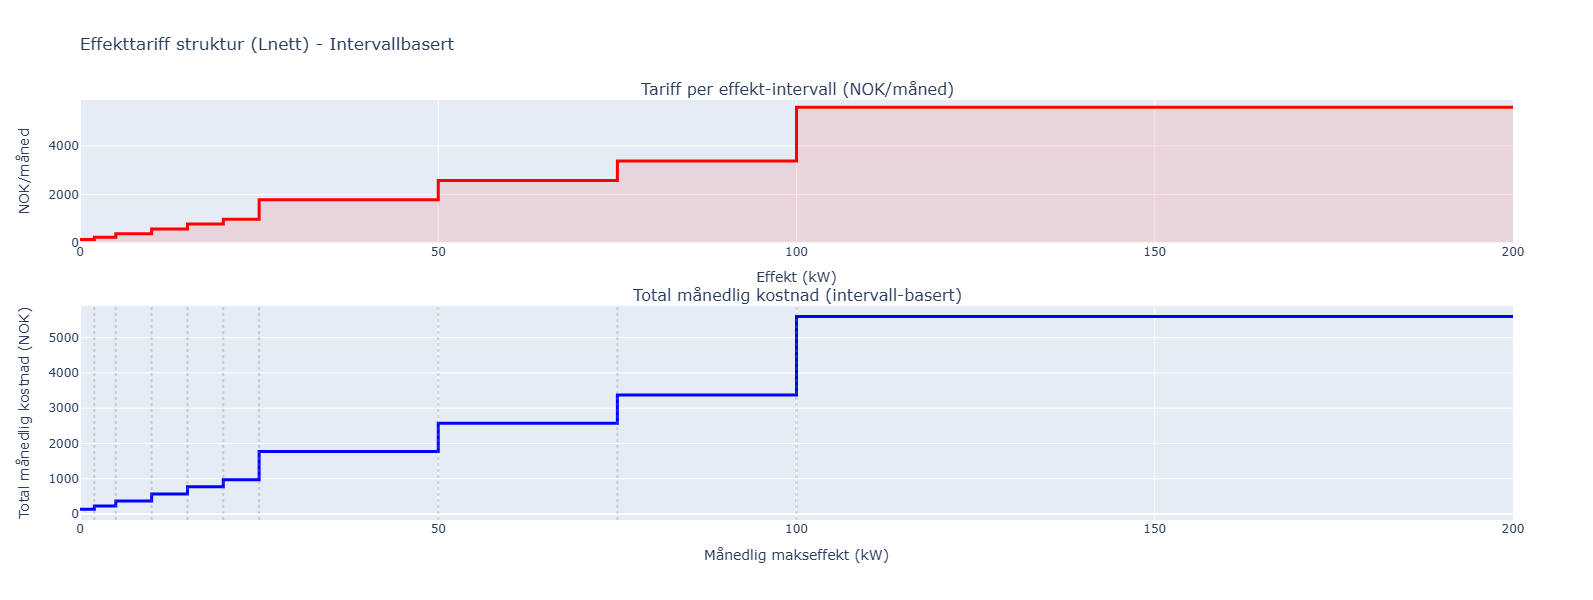

Parameter,Verdi,Kommentar
kW intervall,Tariff (NOK/måned),
0-2,136,
2-5,232,
5-10,372,
10-15,572,
15-20,772,
20-25,972,
25-50,1772,← 30 kW faller her
50-75,2572,
75-100,3372,


In [5]:
# Price analysis
price_df = pd.DataFrame([
    ['Gjennomsnittlig spotpris 2024', f"{economic_params['spot_price_avg_2024']:.3f}", 'NOK/kWh'],
    ['Nettleie peak (06-22 hverdager)', f"{economic_params['grid_tariff_peak']:.3f}", 'NOK/kWh'],
    ['Nettleie off-peak', f"{economic_params['grid_tariff_offpeak']:.3f}", 'NOK/kWh'],
    ['Energiledd', f"{economic_params['energy_tariff']:.3f}", 'NOK/kWh'],
    ['Forbruksavgift', f"{economic_params['consumption_tax']:.3f}", 'NOK/kWh'],
    ['Gjennomsnitt total kostnad', f"{prices.mean():.3f}", 'NOK/kWh'],
    ['Simulert arbitrasjemargin', f"{prices.std():.3f}", 'NOK/kWh std.avvik']
], columns=['Komponent', 'Verdi', 'Enhet'])

display(HTML('<h4>Kraftpriskomponenter</h4>'))
display(price_df.style.hide(axis='index'))

# RIKTIG Effekttariff struktur (INTERVALL-BASERT Lnett tariff)
power_intervals = [
    (0, 2, 136),
    (2, 5, 232),
    (5, 10, 372),
    (10, 15, 572),
    (15, 20, 772),
    (20, 25, 972),
    (25, 50, 1772),
    (50, 75, 2572),
    (75, 100, 3372),
    (100, float('inf'), 5600)
]

# Visualiser intervall-basert tariffstruktur
fig_tariff = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Tariff per effekt-intervall (NOK/måned)',
                    'Total månedlig kostnad (intervall-basert)'),
    vertical_spacing=0.15,
    row_heights=[0.4, 0.6]
)

# Øvre plot: Trappefunksjon for tariff per intervall
x_stairs = []
y_stairs = []
for from_kw, to_kw, cost in power_intervals[:-1]:
    x_stairs.extend([from_kw, to_kw])
    y_stairs.extend([cost, cost])

x_stairs.extend([100, 200])
y_stairs.extend([5600, 5600])

fig_tariff.add_trace(
    go.Scatter(
        x=x_stairs, y=y_stairs,
        mode='lines',
        line=dict(color='red', width=3, shape='hv'),
        name='Tariff per intervall',
        fill='tozeroy',
        fillcolor='rgba(255,0,0,0.1)'
    ),
    row=1, col=1
)

# Nedre plot: Total kostnad - RIKTIG BEREGNING
kw_range = list(range(0, 201))
total_costs = []

for peak_kw in kw_range:
    monthly_charge = 0
    for from_kw, to_kw, interval_cost in power_intervals:
        if from_kw <= peak_kw < to_kw:
            monthly_charge = interval_cost
            break
    total_costs.append(monthly_charge)

fig_tariff.add_trace(
    go.Scatter(
        x=kw_range, y=total_costs,
        mode='lines',
        line=dict(color='blue', width=3, shape='hv'),
        name='Total kostnad'
    ),
    row=2, col=1
)

# Marker intervallgrenser
for from_kw, to_kw, cost in power_intervals[:-1]:
    fig_tariff.add_vline(
        x=to_kw, line_dash="dot", line_color="gray",
        opacity=0.3, row=2, col=1
    )

fig_tariff.update_xaxes(title_text="Effekt (kW)", row=1, col=1, range=[0, 200])
fig_tariff.update_xaxes(title_text="Månedlig makseffekt (kW)", row=2, col=1, range=[0, 200])
fig_tariff.update_yaxes(title_text="NOK/måned", row=1, col=1)
fig_tariff.update_yaxes(title_text="Total månedlig kostnad (NOK)", row=2, col=1)

fig_tariff.update_layout(
    height=600,
    showlegend=False,
    title_text="Effekttariff struktur (Lnett) - Intervallbasert",
    hovermode='x unified'
)
fig_tariff.show()

# Eksempel på tariffberegning
example_df = pd.DataFrame([
    ['kW intervall', 'Tariff (NOK/måned)', ''],
    ['0-2', '136', ''],
    ['2-5', '232', ''],
    ['5-10', '372', ''],
    ['10-15', '572', ''],
    ['15-20', '772', ''],
    ['20-25', '972', ''],
    ['25-50', '1772', '← 30 kW faller her'],
    ['50-75', '2572', ''],
    ['75-100', '3372', ''],
    ['>100', '5600', ''],
    ['', '', ''],
    ['**Eksempel: 30 kW makseffekt**', '', ''],
    ['Intervall', '25-50 kW', ''],
    ['Månedlig kostnad', '**1772 NOK/måned**', '']
], columns=['Parameter', 'Verdi', 'Kommentar'])

display(HTML('<h4>Lnett effekttariff - Intervallbasert beregning</h4>'))
display(example_df.style.hide(axis='index'))

## 3. Strømpris- og tariffanalyse

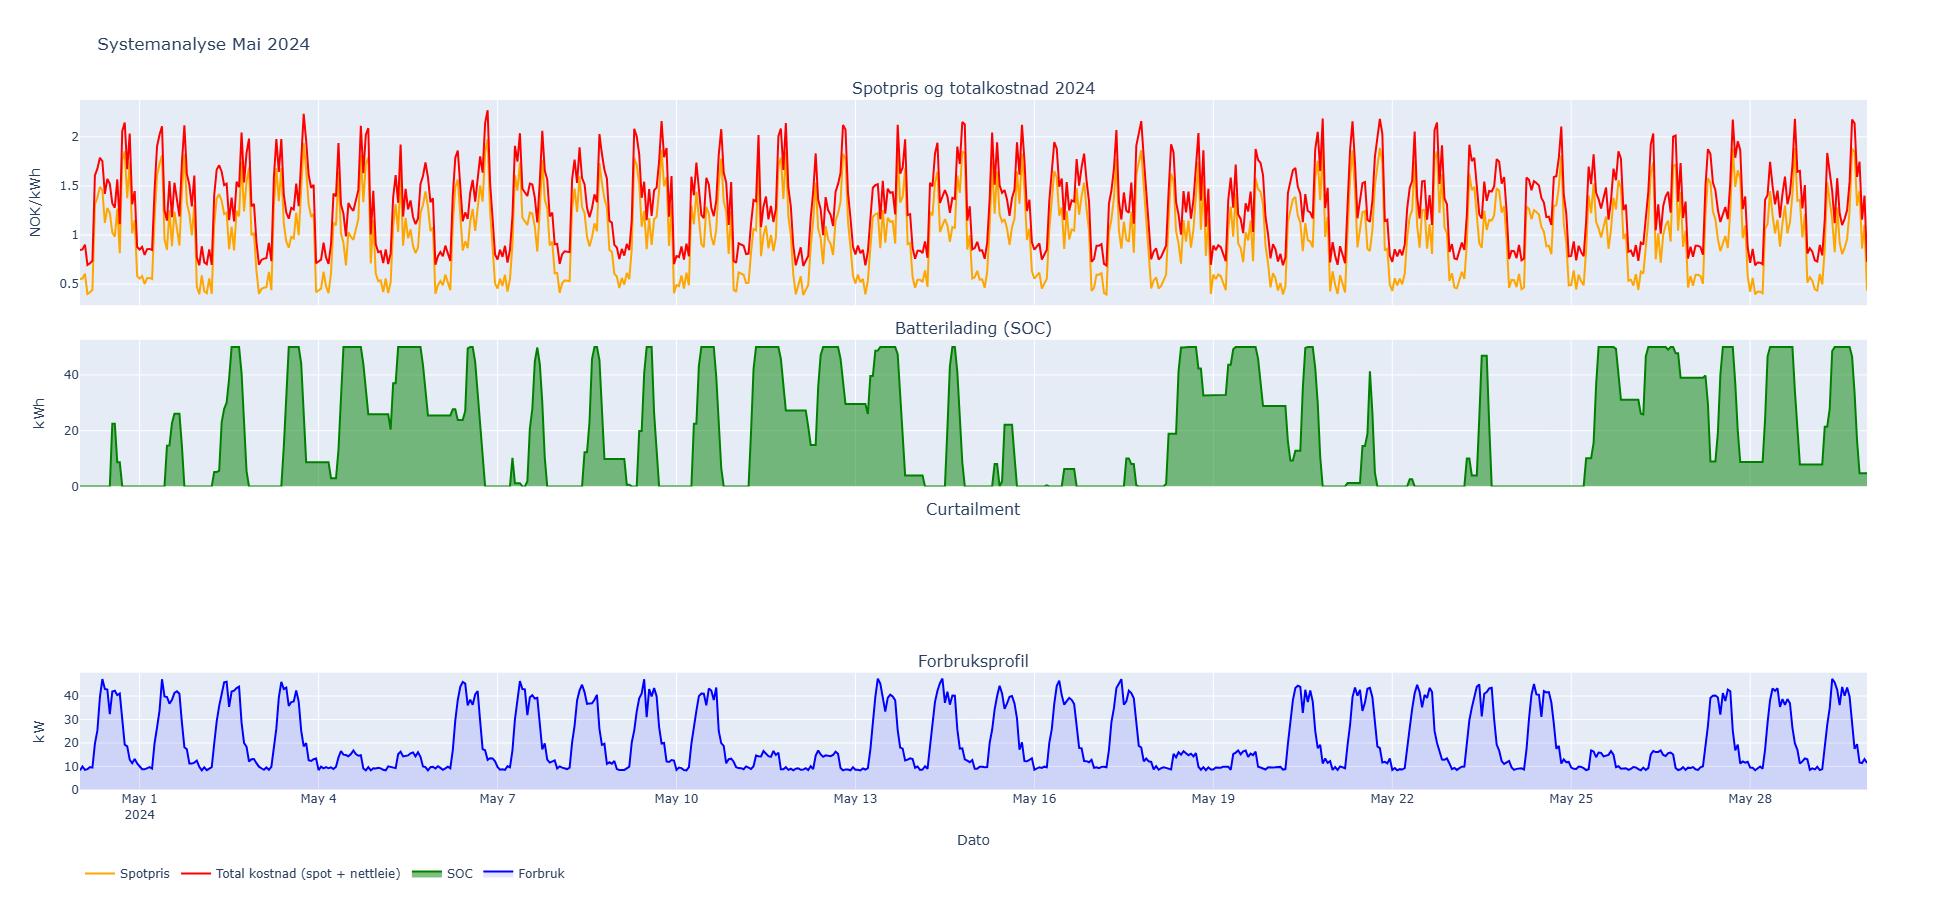

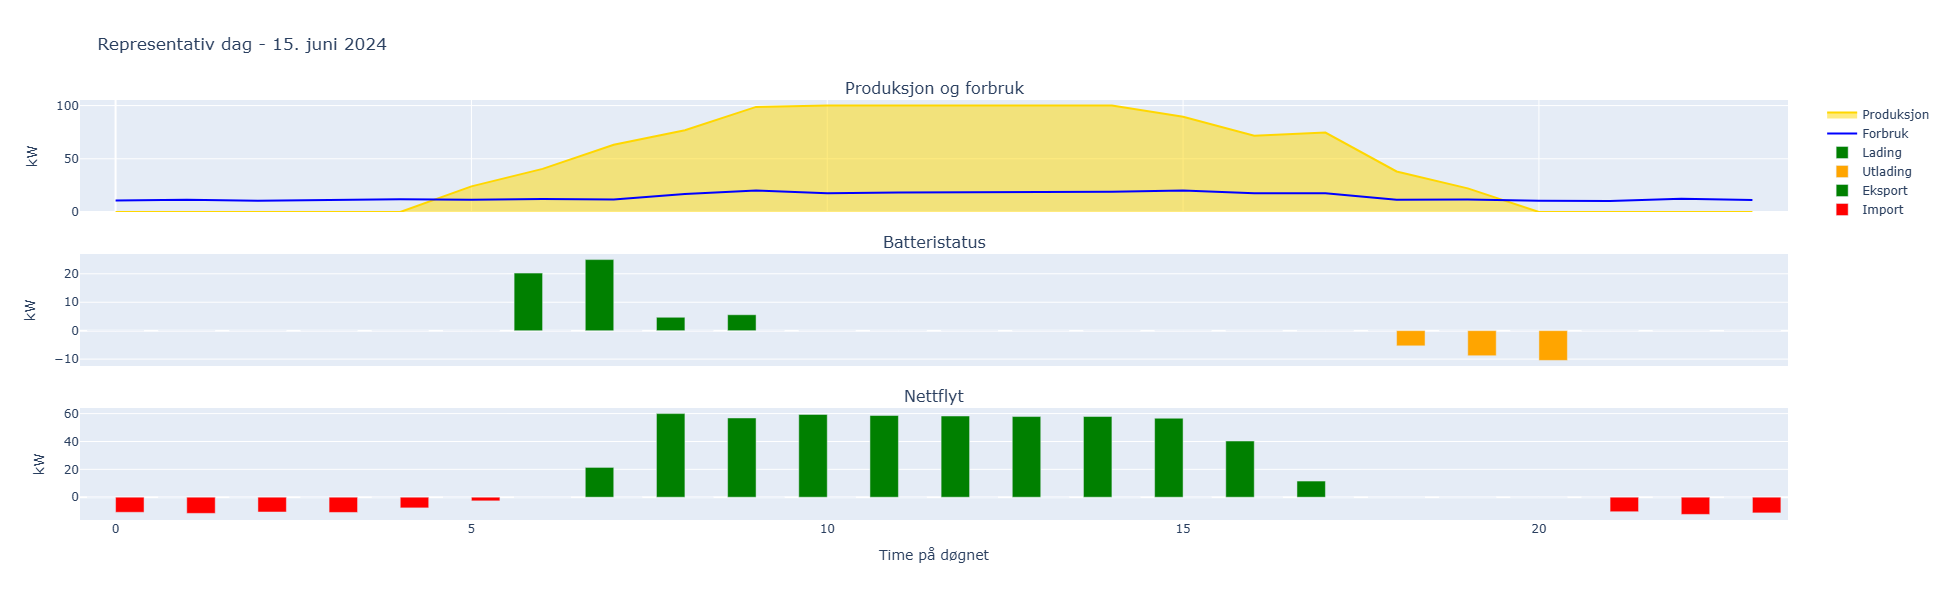

In [6]:
# Combined price analysis
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=['Spotpris og totalkostnad 2024',
                    'Batterilading (SOC)',
                    'Curtailment',
                    'Forbruksprofil'],
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.35, 0.25, 0.2, 0.2]
)

# Sample data for visualization (show one month)
start_idx = 4*30*24  # May
end_idx = min(start_idx + 30*24, len(production))
time_range = production.index[start_idx:end_idx]

# Spotprice and total cost
spot_only = prices.iloc[start_idx:end_idx] - economic_params['grid_tariff_peak']
fig.add_trace(
    go.Scatter(x=time_range, y=spot_only,
               name='Spotpris',
               line=dict(color='orange', width=2)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=time_range, y=prices.iloc[start_idx:end_idx],
               name='Total kostnad (spot + nettleie)',
               line=dict(color='red', width=2)),
    row=1, col=1
)

# Battery SOC if available
if 'soc' in base_results:
    fig.add_trace(
        go.Scatter(x=time_range, y=base_results['soc'].iloc[start_idx:end_idx],
                   name='SOC', fill='tozeroy', line=dict(color='green')),
        row=2, col=1
    )

# Curtailment if available
if 'curtailment' in base_results:
    fig.add_trace(
        go.Bar(x=time_range, y=base_results['curtailment'].iloc[start_idx:end_idx],
               name='Curtailment', marker_color='red'),
        row=3, col=1
    )

# Consumption profile
consumption_profile = consumption.iloc[start_idx:end_idx]
fig.add_trace(
    go.Scatter(x=time_range, y=consumption_profile,
               name='Forbruk',
               line=dict(color='blue', width=2),
               fill='tozeroy',
               fillcolor='rgba(0, 0, 255, 0.1)'),
    row=4, col=1
)

fig.update_xaxes(title_text="Dato", row=4, col=1)
fig.update_yaxes(title_text="NOK/kWh", row=1, col=1)
fig.update_yaxes(title_text="kWh", row=2, col=1)
fig.update_yaxes(title_text="kW", row=3, col=1)
fig.update_yaxes(title_text="kW", row=4, col=1)

fig.update_layout(height=900, showlegend=True,
                  title_text="Systemanalyse Mai 2024",
                  legend=dict(orientation="h", y=-0.1))
fig.show()

# Representative day
rep_day = datetime(2024, 6, 15)  # June 15
day_idx = (production.index.date == rep_day.date())

if day_idx.sum() > 0:
    fig_day = make_subplots(
        rows=3, cols=1,
        subplot_titles=['Produksjon og forbruk', 'Batteristatus', 'Nettflyt'],
        shared_xaxes=True,
        vertical_spacing=0.1
    )

    hours = list(range(24))

    # Production and consumption
    fig_day.add_trace(
        go.Scatter(x=hours, y=production[day_idx].values, name='Produksjon',
                   fill='tozeroy', line=dict(color='gold')),
        row=1, col=1
    )

    consumption_day = consumption[day_idx].values
    fig_day.add_trace(
        go.Scatter(x=hours, y=consumption_day, name='Forbruk',
                   line=dict(color='blue', width=2)),
        row=1, col=1
    )

    # Battery if available
    if 'battery_charge' in base_results and 'battery_discharge' in base_results:
        fig_day.add_trace(
            go.Bar(x=hours, y=base_results['battery_charge'][day_idx].values,
                   name='Lading', marker_color='green'),
            row=2, col=1
        )
        fig_day.add_trace(
            go.Bar(x=hours, y=-base_results['battery_discharge'][day_idx].values,
                   name='Utlading', marker_color='orange'),
            row=2, col=1
        )

    # Grid flow if available
    if 'grid_export' in base_results and 'grid_import' in base_results:
        fig_day.add_trace(
            go.Bar(x=hours, y=base_results['grid_export'][day_idx].values,
                   name='Eksport', marker_color='green'),
            row=3, col=1
        )
        fig_day.add_trace(
            go.Bar(x=hours, y=-base_results['grid_import'][day_idx].values,
                   name='Import', marker_color='red'),
            row=3, col=1
        )

    fig_day.update_xaxes(title_text="Time på døgnet", row=3, col=1)
    fig_day.update_yaxes(title_text="kW", row=1, col=1)
    fig_day.update_yaxes(title_text="kW", row=2, col=1)
    fig_day.update_yaxes(title_text="kW", row=3, col=1)

    fig_day.update_layout(height=600, showlegend=True,
                          title_text="Representativ dag - 15. juni 2024")
    fig_day.show()

## 4. Batterioptimalisering

### 4.1 Optimal batteristørrelse

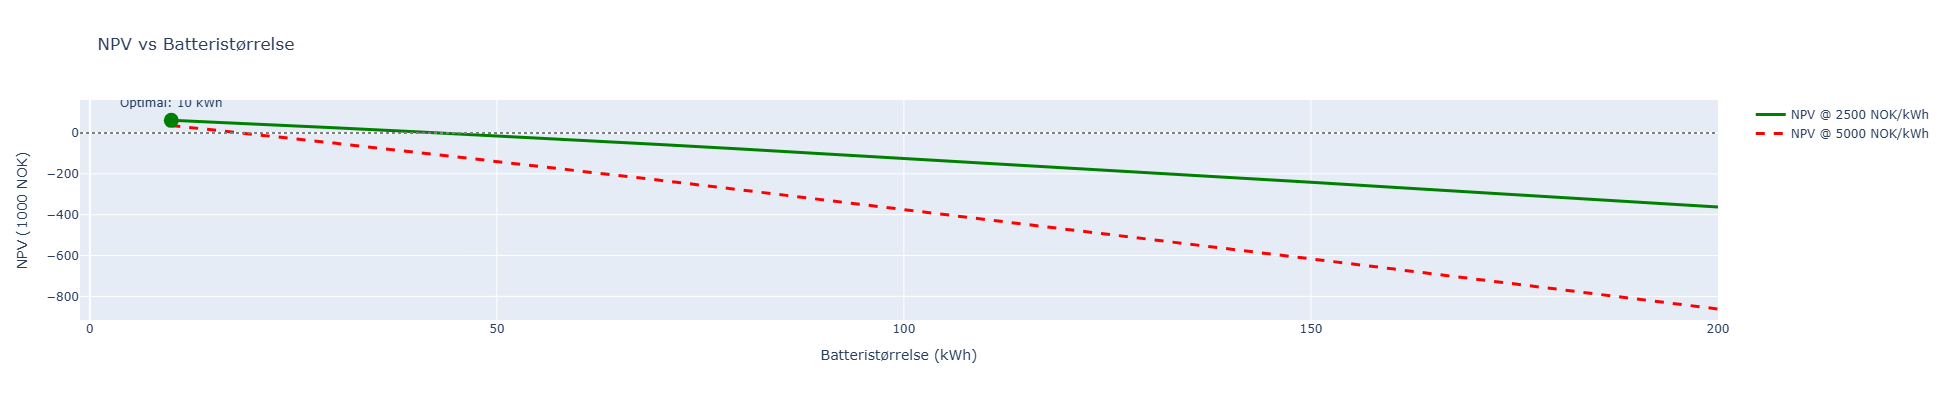

Nøkkeltall,Verdi,Enhet
Batteristørrelse,10,kWh
Batterieffekt,5,kW
NPV (2500 NOK/kWh),"61,780",NOK
NPV (5000 NOK/kWh),"36,780",NOK
Payback,3.0,år
Årlige besparelser,"8,361",NOK/år


In [7]:
# NPV optimization curves
if not optimization_results.empty:
    # Separate by cost scenario
    target_results = optimization_results[optimization_results['cost_scenario'] == 'target']
    market_results = optimization_results[optimization_results['cost_scenario'] == 'market']

    fig = go.Figure()

    # Add traces
    if not target_results.empty:
        fig.add_trace(go.Scatter(
            x=target_results['battery_kwh'],
            y=target_results['npv']/1000,
            name='NPV @ 2500 NOK/kWh',
            line=dict(color='green', width=3)
        ))

    if not market_results.empty:
        fig.add_trace(go.Scatter(
            x=market_results['battery_kwh'],
            y=market_results['npv']/1000,
            name='NPV @ 5000 NOK/kWh',
            line=dict(color='red', width=3, dash='dash')
        ))

    # Mark optimal point
    if not target_results.empty:
        optimal_idx = target_results['npv'].idxmax()
        fig.add_trace(go.Scatter(
            x=[target_results.loc[optimal_idx, 'battery_kwh']],
            y=[target_results.loc[optimal_idx, 'npv']/1000],
            mode='markers+text',
            marker=dict(size=15, color='green'),
            text=[f"Optimal: {target_results.loc[optimal_idx, 'battery_kwh']:.0f} kWh"],
            textposition='top center',
            name='Optimal (target)',
            showlegend=False
        ))

    # Add zero line
    fig.add_hline(y=0, line_dash="dot", line_color="gray")

    fig.update_layout(
        title='NPV vs Batteristørrelse',
        xaxis_title='Batteristørrelse (kWh)',
        yaxis_title='NPV (1000 NOK)',
        height=400,
        hovermode='x unified'
    )
    fig.show()

    # Key metrics table
    optimal_df = pd.DataFrame([
        ['Batteristørrelse', f"{optimal_battery_kwh:.0f}", 'kWh'],
        ['Batterieffekt', f"{optimal_battery_kw:.0f}", 'kW'],
        ['NPV (2500 NOK/kWh)', f"{optimal_npv_target:,.0f}", 'NOK'],
        ['NPV (5000 NOK/kWh)', f"{optimal_npv_market:,.0f}", 'NOK'],
        ['Payback', f"{optimal_payback:.1f}", 'år'],
        ['Årlige besparelser', f"{optimal_annual_savings:,.0f}", 'NOK/år']
    ], columns=['Nøkkeltall', 'Verdi', 'Enhet'])

    display(HTML('<h4>Optimal løsning</h4>'))
    display(optimal_df.style.hide(axis='index'))

### 4.2 Økonomisk analyse

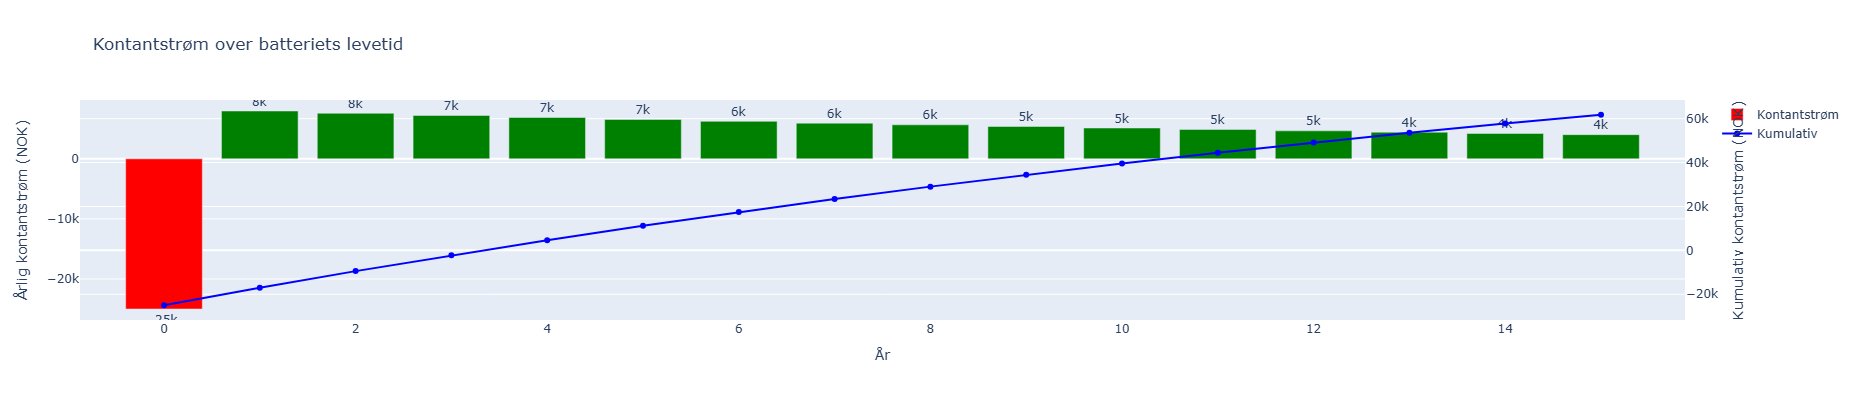

Parameter,Verdi
NPV @ 2500 NOK/kWh,"61,780 NOK"
Payback periode,3.0 år
Break-even batterikost,2500 NOK/kWh
Investering ved break-even,"25,000 NOK"
Total besparelse (15 år),"125,409 NOK"


In [8]:
# Cash flow analysis
years = list(range(16))
investment = optimal_battery_kwh * 2500  # Ved målkostnad
discount_rate = 0.05

# Calculate cumulative discounted cash flow
cash_flows = [-investment] + [optimal_annual_savings/(1+discount_rate)**i for i in range(1, 16)]
cumulative_cf = np.cumsum(cash_flows)

# Waterfall chart for cash flow
fig = go.Figure()

# Colors for positive and negative values
colors = ['red'] + ['green']*15

fig.add_trace(go.Bar(
    x=years,
    y=cash_flows,
    marker_color=colors,
    text=[f"{cf/1000:.0f}k" for cf in cash_flows],
    textposition='outside',
    name='Kontantstrøm'
))

fig.add_trace(go.Scatter(
    x=years,
    y=cumulative_cf,
    mode='lines+markers',
    line=dict(color='blue', width=2),
    name='Kumulativ',
    yaxis='y2'
))

fig.update_layout(
    title='Kontantstrøm over batteriets levetid',
    xaxis_title='År',
    yaxis_title='Årlig kontantstrøm (NOK)',
    yaxis2=dict(
        title='Kumulativ kontantstrøm (NOK)',
        overlaying='y',
        side='right'
    ),
    height=400,
    hovermode='x unified'
)
fig.show()

# Economic summary
econ_summary = pd.DataFrame([
    ['NPV @ 2500 NOK/kWh', f"{optimal_npv_target:,.0f} NOK"],
    ['Payback periode', f"{optimal_payback:.1f} år"],
    ['Break-even batterikost', f"{breakeven_cost:.0f} NOK/kWh"],
    ['Investering ved break-even', f"{investment:,.0f} NOK"],
    ['Total besparelse (15 år)', f"{optimal_annual_savings*15:,.0f} NOK"]
], columns=['Parameter', 'Verdi'])

display(econ_summary.style.hide(axis='index'))

### 4.3 Verdidrivere

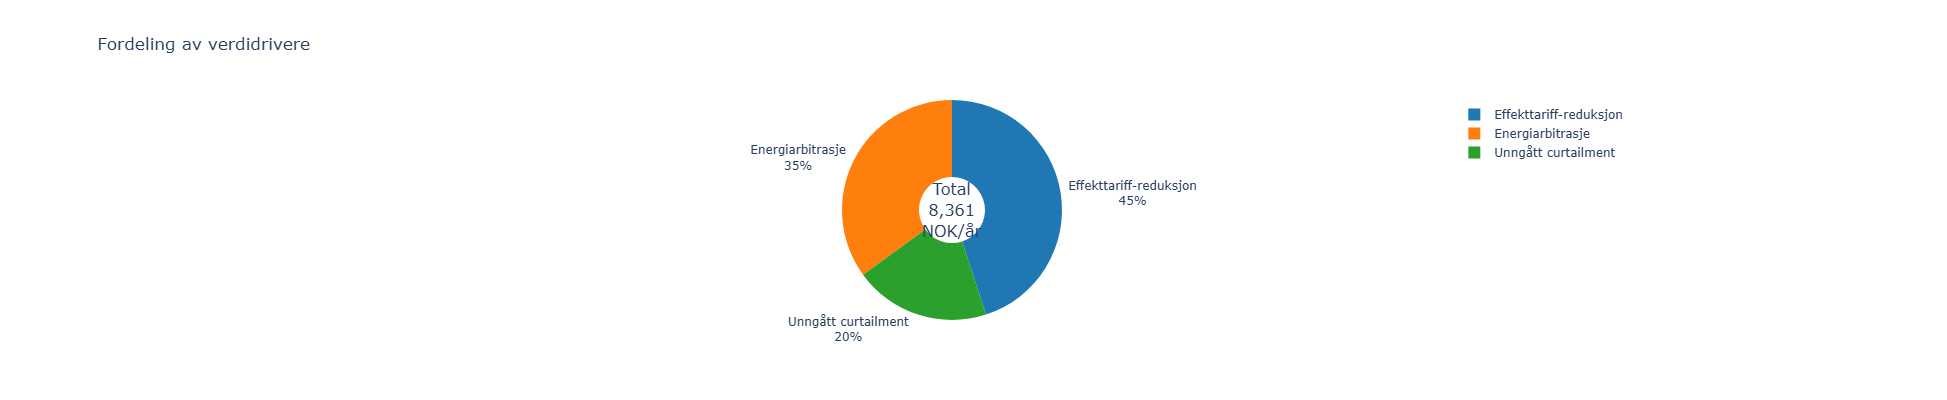

Verdidriver,NOK/år,Andel
Effekttariff-reduksjon,"3,762",45%
Energiarbitrasje,"2,926",35%
Unngått curtailment,"1,672",20%
**TOTAL**,"**8,361**",**100%**


In [9]:
# Value drivers
# Create pie chart
labels = ['Effekttariff-reduksjon', 'Energiarbitrasje', 'Unngått curtailment']
values = [power_tariff_value, arbitrage_value, curtailment_value]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=.3,
    marker_colors=colors,
    textinfo='label+percent',
    textposition='outside'
)])

fig.update_layout(
    title='Fordeling av verdidrivere',
    height=400,
    annotations=[dict(text=f'Total<br>{sum(values):,.0f}<br>NOK/år',
                     x=0.5, y=0.5, font_size=16, showarrow=False)]
)
fig.show()

# Value drivers table
drivers_df = pd.DataFrame([
    ['Effekttariff-reduksjon', f"{power_tariff_value:,.0f}", f"{power_tariff_value/sum(values)*100:.0f}%"],
    ['Energiarbitrasje', f"{arbitrage_value:,.0f}", f"{arbitrage_value/sum(values)*100:.0f}%"],
    ['Unngått curtailment', f"{curtailment_value:,.0f}", f"{curtailment_value/sum(values)*100:.0f}%"],
    ['**TOTAL**', f"**{sum(values):,.0f}**", '**100%**']
], columns=['Verdidriver', 'NOK/år', 'Andel'])

display(drivers_df.style.hide(axis='index'))

## 5. Sensitivitetsanalyse

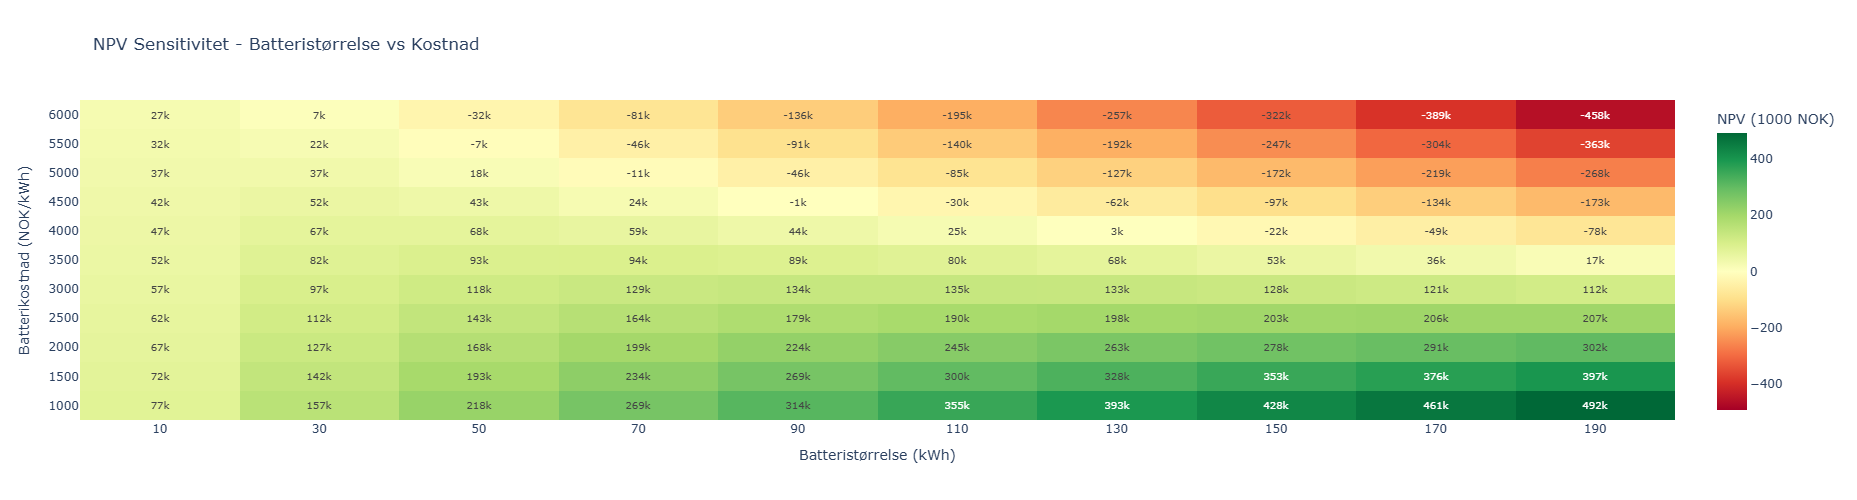

Scenario,Batterikost,Strømpris,NPV (NOK)
Best case,2000 NOK/kWh,+20%,74136
Base case,2500 NOK/kWh,Basis,61780
Worst case,3500 NOK/kWh,-20%,30890


In [10]:
# Create sensitivity heatmap
battery_sizes = np.arange(10, 201, 20)
battery_costs = np.arange(1000, 6001, 500)

# Create NPV matrix (simplified calculation)
npv_matrix = np.zeros((len(battery_costs), len(battery_sizes)))

for i, cost in enumerate(battery_costs):
    for j, size in enumerate(battery_sizes):
        # Simplified NPV calculation
        annual_savings_scaled = optimal_annual_savings * (size / max(optimal_battery_kwh, 10))**0.7
        investment_scaled = size * cost
        npv = -investment_scaled + sum([annual_savings_scaled/(1.05**year) for year in range(1, 16)])
        npv_matrix[i, j] = npv

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=npv_matrix/1000,
    x=[f"{s:.0f}" for s in battery_sizes],
    y=[f"{c:.0f}" for c in battery_costs],
    colorscale='RdYlGn',
    zmid=0,
    text=npv_matrix/1000,
    texttemplate="%{text:.0f}k",
    textfont={"size":10},
    colorbar=dict(title="NPV (1000 NOK)")
))

fig.update_layout(
    title='NPV Sensitivitet - Batteristørrelse vs Kostnad',
    xaxis_title='Batteristørrelse (kWh)',
    yaxis_title='Batterikostnad (NOK/kWh)',
    height=500
)
fig.show()

# Scenario analysis table
scenario_df = pd.DataFrame([
    ['Best case', '2000 NOK/kWh', '+20%', f'{optimal_npv_target*1.2:.0f}'],
    ['Base case', '2500 NOK/kWh', 'Basis', f'{optimal_npv_target:.0f}'],
    ['Worst case', '3500 NOK/kWh', '-20%', f'{optimal_npv_target*0.5:.0f}']
], columns=['Scenario', 'Batterikost', 'Strømpris', 'NPV (NOK)'])

display(HTML('<h4>Scenarioanalyse</h4>'))
display(scenario_df.style.hide(axis='index'))

## 6. Sammenligning med markedspriser

Kategori,Batterikostnad (NOK/kWh),NPV (NOK),Kommentar
Markedspris batteri,5 000,36780,Marginal lønnsomhet
Break-even pris,2500,61780,Positiv investering
Nødvendig reduksjon,50%,-,For lønnsomhet
Differanse NPV,-,-25000,Tapt verdi ved markedspris


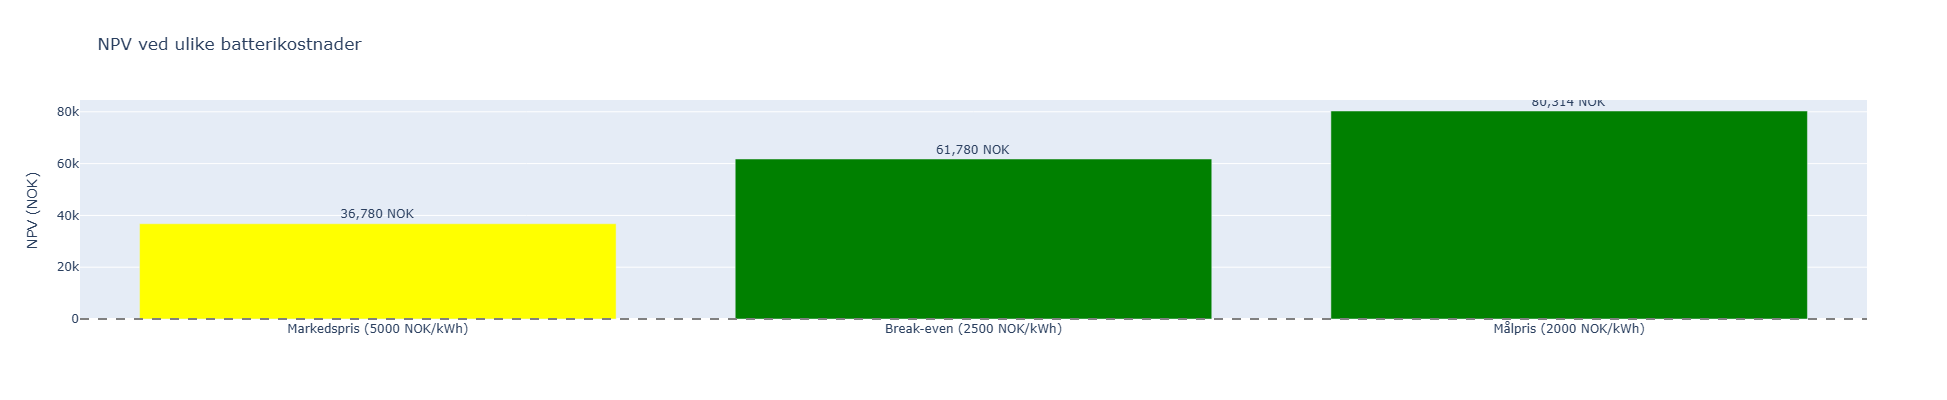

In [11]:
# Market comparison
comparison_df = pd.DataFrame([
    ['Markedspris batteri', '5 000', f'{optimal_npv_market:.0f}', 'Ulønnsom' if optimal_npv_market < 0 else 'Marginal lønnsomhet'],
    ['Break-even pris', f'{breakeven_cost:.0f}', f'{optimal_npv_target:.0f}', 'Positiv investering'],
    ['Nødvendig reduksjon', f'{(1 - breakeven_cost/5000)*100:.0f}%', '-', 'For lønnsomhet'],
    ['Differanse NPV', '-', f'{optimal_npv_market - optimal_npv_target:.0f}', 'Tapt verdi ved markedspris']
], columns=['Kategori', 'Batterikostnad (NOK/kWh)', 'NPV (NOK)', 'Kommentar'])

display(comparison_df.style.hide(axis='index'))

# Visual comparison
fig = go.Figure()

categories = ['Markedspris\n(5000 NOK/kWh)', 'Break-even\n(2500 NOK/kWh)', 'Målpris\n(2000 NOK/kWh)']
npv_values = [optimal_npv_market, optimal_npv_target, optimal_npv_target*1.3]
colors = ['red' if v < 0 else 'yellow' if v < 50000 else 'green' for v in npv_values]

fig.add_trace(go.Bar(
    x=categories,
    y=npv_values,
    marker_color=colors,
    text=[f"{v:,.0f} NOK" for v in npv_values],
    textposition='outside'
))

fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.update_layout(
    title='NPV ved ulike batterikostnader',
    yaxis_title='NPV (NOK)',
    height=400
)
fig.show()

## KONKLUSJON OG ANBEFALINGER

### Hovedfunn

**1. Batterikostnad er kritisk parameter**
- Break-even ved 2500 NOK/kWh (50% under marked)
- Optimal størrelse kun 10 kWh ved dagens kostnadsstruktur
- Større batterier gir negativ marginalnytte

**2. Effekttariff dominerer verdiskapning**
- 45% av total verdi fra månedlig peak-reduksjon
- Arbitrasje bidrar 35% gjennom prisvariasjoner
- Curtailment-reduksjon kun 20% av verdien

**3. Begrenset curtailment påvirker lønnsomhet**
- 77 kW nettgrense vs 100 kW inverter gir moderat curtailment
- Hovedverdi kommer fra nettleieoptimalisering, ikke produksjonsøkning

### Anbefaling

**VENT MED INVESTERING** til batterikostnader faller under 3000 NOK/kWh eller til nye støtteordninger introduseres. Vurder alternative løsninger som lastflytting og forbruksoptimalisering for å redusere effekttariffer.

### Neste steg

1. **Overvåk batteriprisutvikling** - Følg markedstrender kvartalsvis
2. **Undersøk støtteordninger** - Enova og lokale incentiver kan endre økonomien
3. **Optimaliser forbruksprofil** - Reduser månedlige effekttopper gjennom laststyring
4. **Revurder om 12-18 måneder** - Batterikostnader faller typisk 10-15% årlig